In [1]:
%load_ext autoreload
%autoreload 2
from storytelling import *
from bert_extractive_summarizer.summarizer import Summarizer
from bert_extractive_summarizer.summarizer.coreference_handler import CoreferenceHandler
tool = language_check.LanguageTool('en-US')

/data/jw3514/anaconda3/envs/storytell/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/data/jw3514/anaconda3/envs/storytell/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/data/jw3514/anaconda3/envs/storytell/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/data/jw3514/anaconda3/envs/storytell

#### Load  glove twitter Word embeddings

In [2]:
word_embeddings = LoadWordEmbeddings(fil="../dat/glove/glove.twitter.27B.100d.txt")

##### Load tweets and preprocess

In [3]:
datfile = "../dat/wildfire_yosemite.csv"
#datfile = "../dat/4499.csv.gz"
#datfile = "../dat/232.csv.gz"
#datfile = "../dat/4884.csv.gz"
df = pd.read_csv(datfile, index_col="id")
df = df[df["rt_id"].isna()] # Drop retweets
print(df.shape)
df.head(5)

(3582, 11)


,text,created_at,retweet_count,user_id,user_followers_count,rt_id,rt_text,rt_created_at,rt_retweet_count,rt_user_id,rt_user_followers_count
id,,,,,,,,,,,
370587609350684672,Yosemite area wildfire balloons in size overni...,Thu Aug 22 16:45:45 +0000 2013,0,513774875,3643,NaN,NaN,NaN,NaN,NaN,NaN
370595563042906112,#Yosemite-area Wildfire Balloons In Size Overn...,Thu Aug 22 17:17:22 +0000 2013,0,187353947,3866,NaN,NaN,NaN,NaN,NaN,NaN
370587253325578240,Yosemite-area wildfire balloons in size overni...,Thu Aug 22 16:44:21 +0000 2013,1,15856435,235685,NaN,NaN,NaN,NaN,NaN,NaN
370607661118922752,A wildfire is burning out of control near Yose...,Thu Aug 22 18:05:26 +0000 2013,1,34700777,62034,NaN,NaN,NaN,NaN,NaN,NaN
370605432550600704,Yosemite-area wildfire balloons in size overni...,Thu Aug 22 17:56:35 +0000 2013,1,26304713,4724,NaN,NaN,NaN,NaN,NaN,NaN


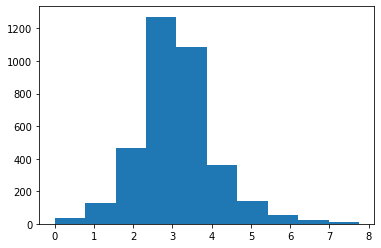

In [4]:
df = df[df["user_followers_count"]>0]
plt.hist(np.log10(df["user_followers_count"].values))
plt.show()

In [19]:
df1 = df[df["user_followers_count"]>10**2]
df1.shape

(3187, 11)

In [20]:
tids, row_sentences, clean_sentences = readsencence(df1)

In [21]:
sentence_vectors = Sentence2WE(clean_sentences, word_embeddings)

(1624, 40)


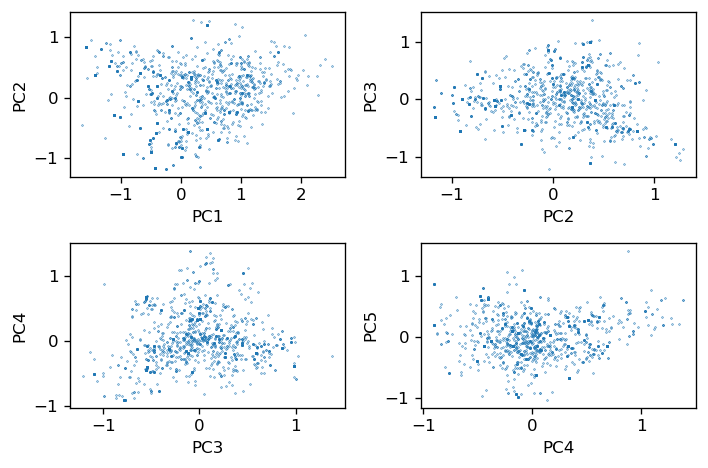

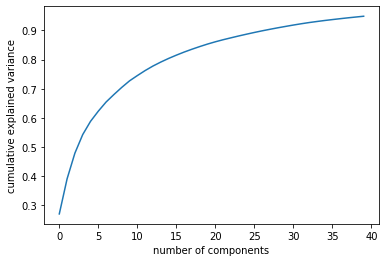

In [22]:
pca = PCA(n_components=40, svd_solver='arpack')
X = pca.fit_transform(sentence_vectors)
print(X.shape)
fig, axs = plt.subplots(2,2,dpi=120)
for i,(j,k) in enumerate([(0,0),(0,1),(1,0),(1,1)]):
    axs[j,k].scatter(X[:,i], X[:,i+1], s=0.1)
    axs[j,k].set_xlabel("PC%d"%(i+1))
    axs[j,k].set_ylabel("PC%d"%(i+2))
fig.tight_layout()
plt.show()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [37]:
NC = 40
for nc, vexp in enumerate(np.cumsum(pca.explained_variance_ratio_)):
    if vexp > 0.9:
        NC = nc+1
        break
print(NC)

28


In [38]:
tsne = TSNE(n_components=2)
Y = tsne.fit_transform(X[:, :NC])

In [39]:
#Agg = sklearn.cluster.AgglomerativeClustering(n_clusters=10, affinity="cosine",linkage="average")
Agg = sklearn.cluster.AgglomerativeClustering(distance_threshold=1.5, n_clusters=None, affinity="cosine",linkage="complete")
Agg = Agg.fit(X[:, :NC])
clusters = Agg.fit_predict(X[:, :NC])
groups = AssignCluster(Y, clusters)
print(len(groups))
#centers = kmeans.cluster_centers_ 

8


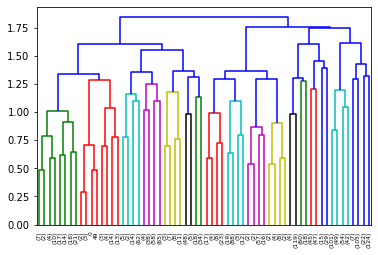

In [40]:
plot_dendrogram(Agg, truncate_mode='level', p=5)

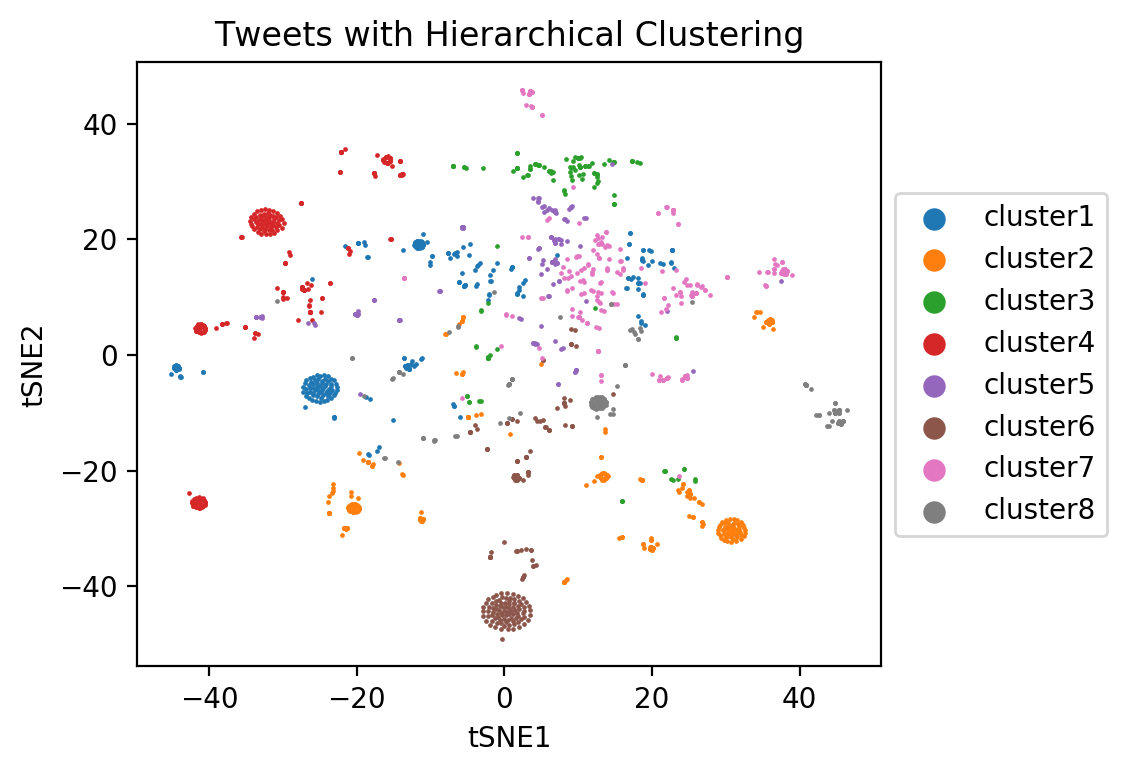

In [41]:
fig = plt.figure(dpi=200)
ax = plt.subplot(111)
for i, group in enumerate(groups):
    group = np.array(group)
    ax.scatter(group[:, 0], group[:, 1], label="cluster%d"%(i+1), s=0.5)
#ax.scatter(centers[:,0], centers[:,1], s=4, color="black", marker="x")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
lgnd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10, markerscale=10.)
ax.set_xlabel("tSNE1")
ax.set_ylabel("tSNE2")
plt.title("Tweets with Hierarchical Clustering")
plt.show()

In [42]:
Totoal_art = []
for i in range(max(clusters)+1):
    topics = np.where(clusters==i)[0]
    if len(topics) < 5:
        continue
    topic_tweet_idxs = np.array([tids[int(i)] for i in topics])
    topic_sentence_vectors = np.array([sentence_vectors[int(i)] for i in topics])
    sim_mat = TextRankScoreMat(topic_sentence_vectors)
    threashold = 0.8
    rm_idx = []
    kept_idx = []
    for i in range(sim_mat.shape[0]):
        if i in rm_idx:
            continue
        kept_idx.append(i)
        for j in range(sim_mat.shape[1]):
            if sim_mat[i,j]>threashold:
                rm_idx.append(j)   
    #print(len(kept_idx))
    art = []
    selected_Clean = []
    for i in kept_idx:
        dat_id = topics[i]
        tid = tids[dat_id]
        date = datetime.strptime(df1.loc[tid, "created_at"],'%a %b %d %X %z %Y').strftime("%m-%d-%X")
        if len(row_sentences[dat_id]) > 20:
            art.append(row_sentences[dat_id])
            selected_Clean.append(clean_sentences[dat_id])
    #print(art)
    Totoal_art.append(".".join(art))
#print(Totoal_art)
print("\n".join(Totoal_art))

wildfire near yosemite grows to 25 square miles.rt" : huge wildfire near yosemite sends tourists fleeing ".yosemite-area wildfire growing at alarming rate.smokey the bear is not impressed  wildfire  sunrise  tahoe  yosemite  rimfire  americanfire  sadface.dry weather fuels yosemite wildfire.photos from the massive yosemite  rimfire wildfire:
update on  california  wildfire:  rim fire near  yosemite spreads to over 53,866 acres."yosemite-area wildfire balloons in size overnight":.theblaze   tcot yosemite-area wildfire balloons to 84 square miles (twincities).(telegraph) tourists flee yosemite wildfire.the latest on the  wildfire threatening  yosemite ahead on  . photo (via ap):.(ap writer leans back in his chair after writing opening paragraph says to himself "nailed it.")." : wildfire spreads to yosemite national park. "
video of the out-of-control wildfire near yosemite.yosemite wildfire triples in size.wildfire near yosemite surges prompts evacuations.firefighters struggle to contain

In [43]:
model = "bert-large-uncased"
hidden = -2
reduce_option = "mean"
model = Summarizer(
    model = model,
    hidden = hidden,
    reduce_option = reduce_option)

In [50]:
import random

All = "\n".join(Totoal_art)
New_ALL = ""
i = 0
last_con = None
for sent in All.split("."):
    #print(sent)
    if len(sent.split()) < 5:
        continue
    sent = sent.strip().strip(":").strip(" ").strip(":").strip(" ")
    if "I" in sent or "We" in sent or "video" in sent or "photo" in sent or "new" in sent or "news" in sent:
        continue
    if len(sent.strip().split()) < 4 or " — " in sent or "$$" in sent:
        continue
    matches = tool.check(sent)
    if len(matches)<=5:
        if i == 0 or i ==1:
            New_ALL = New_ALL + language_check.correct(sent, matches) + ". "
        else:
            while 1:
                con = random.choice(ConnWords)
                if con != last_con:
                    last_con = con
                    break
            if random.random()> 0.3:
                New_ALL = New_ALL + con  + language_check.correct(sent, matches) + ". "
            else:
                New_ALL = New_ALL + language_check.correct(sent, matches) + ". "
        i += 1

In [51]:
print(New_ALL)

Wildfire near Yosemite grows to 25 square miles. Rt” : huge wildfire near Yosemite sends tourists fleeing “. In addion, Yosemite-area wildfire growing at alarming rate. Dry weather fuels Yosemite wildfire. “Yosemite-area wildfire balloons in size overnight”. (telegraph) tourists flee Yosemite wildfire. The latest on the wildfire threatening Yosemite ahead on. (AP writer leans back in his chair after writing opening paragraph says to himself “nailed it. Besides, “ : wildfire spreads to Yosemite national park. Beyond that, Yosemite wildfire triples in size. Also, Wildfire near Yosemite surges prompts evacuations. Firefighters struggle to contain Yosemite wildfire aviation metal. Openfollow wildfire spreads to Yosemite follow back. Yosemite threatened by 165-square-mile fast-spreading blaze. Furthermore, “ Huge wildfire spreads through Yosemite. Also, Tourists residents evacuate as Yosemite wildfire grows exponentially: state college
wildfire near Yosemite burns out of control threatens m

In [52]:
# Bert-summerizer
result = model(New_ALL)
print(result)

Wildfire near Yosemite grows to 25 square miles. Beyond that, Yosemite wildfire triples in size. Furthermore, “ Huge wildfire spreads through Yosemite. Jerry brown declares state of emergency for large growing wildfire near Yosemite national park
wildfire threatens homes and camps near Yosemite -
yosemite-area wildfire balloons in size overnight. Abq yosemite-area wildfire triples in size overnight. In fact, Rimfireca fire fighters lose ground against growing wildfire camp closing info hard.
